In [1]:
import pandas as pd
import numpy as np
import statistics
from functools import reduce
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
data = sm.datasets.macrodata.load_pandas().data
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
data.columns

Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object')

In [4]:
data1 = data[['quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]
data1.index = data["year"]

In [5]:
data1

,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
year,,,,,,,,,,,,,
1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


<AxesSubplot:xlabel='year'>

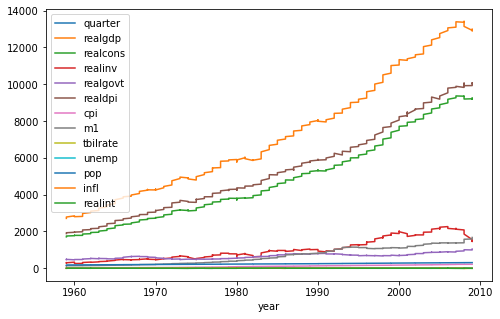

In [6]:
data1.plot(figsize = (8,5))


In [7]:
def skewness(x):
    try:
        if x['mode'] == x['mean'] == x['median']:
            return("symmetric")
        elif x['mode'] > x['median'] > x['mean']:
            return('positive')
        elif x['mean'] > x['median'] > x['mode']:
            return('negative')
        else:
            return('inconclusive')
    except:
        return('inconclusive')

In [8]:
def outlier_share(data, m=3):
    return sum(abs(data - np.mean(data)) > (m * np.std(data)))/len(data)

In [9]:
################ DATA PROFILING ####################
def kde(l, cut_down = True, bw_method = 'scott'):
    if cut_down:
        bins, counts = np.unique(l, return_counts = True)
        f_mean = counts.mean()
        f_above_mean = bins[counts>=f_mean]
        bounds = [f_above_mean.min(), f_above_mean.max()]
        l = l[np.bitwise_and(bounds[0]<l, l<bounds[1])]
        try:
            g = gaussian_kde(l, bw_method = bw_method)
            return g
        except:
            return None

In [10]:
def mode_estimation(l):
    cut_down=True
    bw_method='scott'
    array = np.array(l)
    kernel = kde(array, cut_down=cut_down, bw_method=bw_method)
    bounds = np.array([[array.min(), array.max()]])
    try:
        results = shgo(lambda x: -kernel(x)[0], bounds=bounds, n=100*len(array))
        return results.x[0]
    except:
        return None
    

In [11]:
def get_statistics(base_df: pd.DataFrame,target: str, profiling_cols: list = None) -> pd.DataFrame:
    print(profiling_cols)
    temp = base_df.groupby(profiling_cols, dropna = False)[target].describe().reset_index()
    temp2 = base_df.groupby(profiling_cols, dropna = False)[target].apply(lambda x: x.isna().sum()).reset_index().rename(columns={target:'null_count'})
    temp3 = base_df.groupby(profiling_cols, dropna = False).agg({target:(mode_estimation,np.median)}).reset_index()
    temp3.columns=[temp3.columns[0][0]]+['mode','median']
    temp4 = base_df.groupby(profiling_cols, dropna = False)[target].apply(lambda x: outlier_share(x)).reset_index().rename(columns={target:'outlier_rate'})
    result = reduce(lambda left,right: pd.merge(left,right,on=profiling_cols), [temp, temp2, temp3, temp4])
    result['skewness'] = result.apply(lambda x: skewness(x), axis=1)
    result['coefficient_of_variation'] = result['std']/result['mean']
    return result

In [12]:
def forecast_recommender(df, profiling_col, target):
    p = get_statistics(df,target, [profiling_col])
    p['outlier_flag'] = p.apply(lambda x: 0 if x['outlier_rate']<0.1 else 1, axis = 1)
    p['null_flag'] = p.apply(lambda x: 0 if x['null_count']/x['count']<0.1 else 1, axis = 1)
    p['null_rate'] = p.apply(lambda x: (x['null_count']/x['count'])*100, axis = 1)
    p['outlier_rate'] = p['outlier_rate']*100
    p['variation_flag'] = p.apply(lambda x: 0 if x['coefficient_of_variation']<5 else 1, axis = 1)
    p['total_flag'] = p['outlier_flag']+p['null_flag']+p['variation_flag']
    p['recommended_forecast_type'] = p.apply(lambda x: 'Statistical' if x['total_flag']<=2 else 'Manual', axis = 1)
    p = p.rename(columns = {profiling_col:'forecast_level','count':'number_of_data_points'})
    return p[['forecast_level','null_rate','coefficient_of_variation','outlier_rate','recommended_forecast_type','number_of_data_points']]


In [13]:
data1.columns

Index(['quarter', 'realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi',
       'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object')

In [14]:
forecast_recommender(data,'realgdp', 'realdpi')

['realgdp']


,forecast_level,null_rate,coefficient_of_variation,outlier_rate,recommended_forecast_type,number_of_data_points
0,2710.349,0.0,NaN,0.0,Statistical,1.0
1,2775.488,0.0,NaN,0.0,Statistical,1.0
2,2778.801,0.0,NaN,0.0,Statistical,1.0
3,2785.204,0.0,NaN,0.0,Statistical,1.0
4,2802.616,0.0,NaN,0.0,Statistical,1.0
...,...,...,...,...,...,...
198,13321.109,0.0,NaN,0.0,Statistical,1.0
199,13324.600,0.0,NaN,0.0,Statistical,1.0
200,13366.865,0.0,NaN,0.0,Statistical,1.0
201,13391.249,0.0,NaN,0.0,Statistical,1.0
